In [2]:
versioninfo()

Julia Version 1.6.0
Commit f9720dc2eb* (2021-03-24 12:55 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: AMD EPYC 7702P 64-Core Processor
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, znver2)


In [3]:
mycommand = `pwd`
run(mycommand)

/home/kakizawa/kagome_xy/noneq/J2_-1e-3/L900


Process(`pwd`, ProcessExited(0))

In [4]:
using Interpolations
using Printf
using Optim
using PyPlot
using LinearAlgebra
using HDF5

In [5]:
function read_from_hdf5(h5file,obs_name)
	fid = h5open(h5file,"r")
	temps = fid["temperatures"][:]
	obs   = fid[obs_name*"/mean"]
	times = [i for i in 1:size(obs)[1]]
	return temps,obs,times
end

read_from_hdf5 (generic function with 1 method)

In [6]:
function get_average_obs(num_split,obs_name)
    
    temps,obs,times = read_from_hdf5("2d_split1_out.h5",obs_name)
    num_temps = length(temps[:])
    m_data = zeros(Float64,length(times),num_temps)

    for i in 1:num_split
        ith_temps,ith_obs,ith_times = read_from_hdf5("2d_split$(i)_out.h5",obs_name)
        for j in 1:num_temps
            m_data[:,j] .+= ith_obs[:,j]
           
        end
        
    end
    
    for i in 1:num_temps
        m_data[:,i] ./= num_split
    end
    
    return temps,m_data,times
end

num_split = 5
obs_name = "m_120degs_corr"
temps,m_data,times = get_average_obs(num_split,obs_name)

([0.07, 0.071, 0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08], [1.0 1.0 … 1.0 1.0; 0.41298271272659937 0.4072388141290103 … 0.3660766511419986 0.35999607707709236; … ; 0.1475507633789109 0.14860705978642003 … 0.0003964524924366601 0.00025375006288271657; 0.14760967062148592 0.1489036943567896 … 0.00033351553767862693 0.00024076596786492508], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999, 10000, 10001])

In [7]:
#comment out for the statistical estimation
#=
h5file = "2d_out.h5"
obs_name = "mq_q0_corr"
temps,m_data,times = read_from_hdf5(h5file,obs_name)
=#

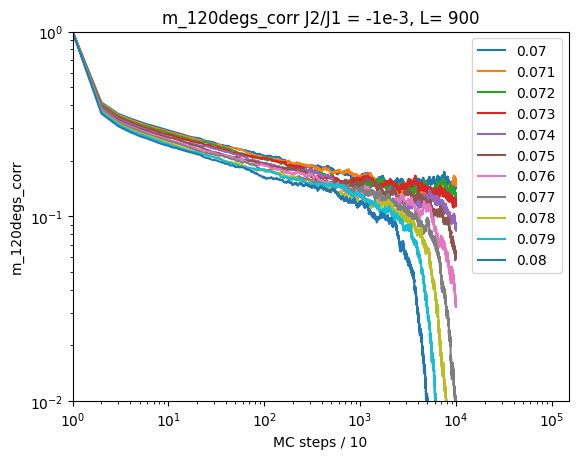

In [8]:
# cut too low temperature datas
num_temps = length(temps)
min_temp  = 1
max_temp  = num_temps
for it in min_temp:max_temp
	plt.semilogy(times,m_data[:,it],label="$(temps[it])")
end
plt.title("$(obs_name) J2/J1 = -1e-3, L= 900")
plt.xlabel("MC steps / 10")
plt.ylabel("$(obs_name)")
plt.xscale("log")
plt.xlim(1,length(times)*15)
plt.ylim(1e-2,1)

plt.legend(loc="upper right")
plt.show()

In [9]:
#=
#load average data from text file
temps = [0.112,0.113,0.114,0.115,0.116]
file_idx = [3,4,5,6,7]
num_temps = length(temps)
mc_steps  = 20000 
m_data = Array{Float64}(undef,mc_steps,num_temps)
counter = 1
for ifl in file_idx
	open("mq_sqrt3_$(ifl).dat","r") do fp
		for is in 1:mc_steps
			str = split(readline(fp))
			m_data[is,counter] = parse(Float64,str[2])
		end
	end
	counter += 1
end
=#

In [10]:
m_data

10001×11 Matrix{Float64}:
 1.0       1.0       1.0       1.0       …  1.0          1.0
 0.412983  0.407239  0.40173   0.39522      0.366077     0.359996
 0.358635  0.354853  0.349203  0.342679     0.313688     0.30718
 0.338147  0.332793  0.326821  0.322013     0.291235     0.285444
 0.325026  0.319702  0.313287  0.3078       0.278404     0.271921
 0.314497  0.309324  0.305489  0.298559  …  0.269537     0.26354
 0.308315  0.302863  0.297234  0.29205      0.261733     0.255464
 0.301982  0.296366  0.291836  0.28524      0.25532      0.248993
 0.296676  0.291871  0.287308  0.279341     0.249784     0.244125
 0.291496  0.286268  0.281681  0.276544     0.24523      0.240762
 0.288021  0.283124  0.27812   0.27334   …  0.240571     0.235854
 0.283869  0.279591  0.274982  0.268844     0.237606     0.234522
 0.280904  0.276951  0.270356  0.265262     0.234667     0.230766
 ⋮                                       ⋱               ⋮
 0.147643  0.146537  0.132515  0.115802     0.00031565   0.00011

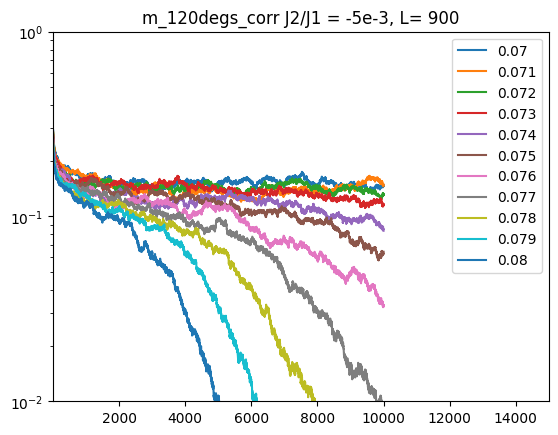

11


In [11]:
num_temps = length(temps)
println(num_temps)
times = [i for i in 1:size(m_data)[1]]
for it in 1:num_temps
	plt.semilogy(times[10:end],m_data[:,it][10:end],label="$(temps[it])")
end
plt.title("$(obs_name) J2/J1 = -5e-3, L= 900")
#plt.xscale("log")
plt.xlim(1,length(times)*1.5)
plt.ylim(1e-2,1)
plt.legend(loc="upper right")
plt.show()

In [12]:
# reshape some datas for optimization.
min_temp = 6
max_temp = 10
temps  = temps[min_temp:max_temp]
num_temps = length(temps)
m_data = m_data[:,min_temp:max_temp]


10001×5 Matrix{Float64}:
 1.0        1.0        1.0         1.0         1.0
 0.385197   0.379986   0.375805    0.370031    0.366077
 0.333098   0.326254   0.323136    0.317007    0.313688
 0.311728   0.306957   0.302428    0.295892    0.291235
 0.297825   0.292728   0.288561    0.282       0.278404
 0.289567   0.28276    0.277915    0.273466    0.269537
 0.280821   0.276061   0.270607    0.267138    0.261733
 0.276728   0.269558   0.266236    0.259562    0.25532
 0.270108   0.264469   0.260466    0.255193    0.249784
 0.266797   0.260167   0.255799    0.248631    0.24523
 0.265296   0.256222   0.252161    0.245929    0.240571
 0.26158    0.253248   0.249275    0.243227    0.237606
 0.258517   0.250866   0.246185    0.238257    0.234667
 ⋮                                             
 0.0621591  0.0328348  0.00882486  0.00278027  0.00031565
 0.0624645  0.0326424  0.00872331  0.00267199  0.000326084
 0.0629394  0.0324398  0.00841757  0.0026154   0.000342582
 0.0630324  0.0327035  0.00854

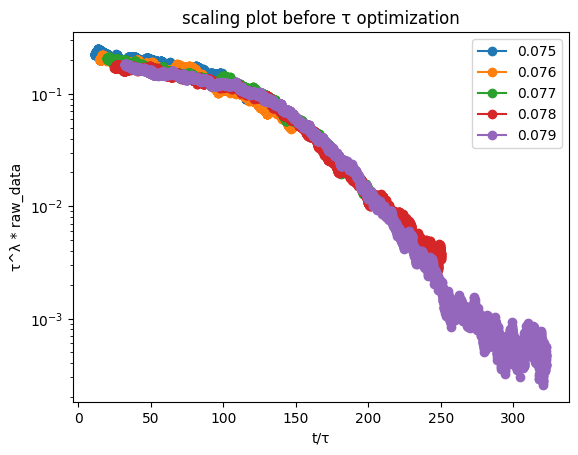

In [13]:
# search configuration of tau which put some curves on one curve.
taus   = [85.,68.,50.,40.,31.]
@assert length(taus) == max_temp - min_temp + 1
lambda = 0.1
start  = 1000
plt.figure()
for it in 1:num_temps
	plt.semilogy(times[start:end] ./ taus[it],(taus[it]^lambda)*m_data[:,it][start:end],marker="o",label="$(temps[it])")
	
end
plt.title("scaling plot before τ optimization")
plt.xlabel("t/τ")
plt.ylabel("τ^λ * raw_data")
plt.legend(loc="upper right")
plt.show()

In [14]:
"""
params: [tau1, tau2, ...]
"""
newaxis = [CartesianIndex()]
function cost(params)
    taus = params
    nx_smpl = 10
    x_u = minimum(times[end] ./ taus)
    x_l = maximum(times[start] ./ taus)
    xs_smpl = range(x_l, x_u, length=nx_smpl)
    g_intpl = zeros((nx_smpl, length(temps)))
    for it in eachindex(temps)
        tau = taus[it]
        xs = times ./ tau
        g_data = tau^lambda * m_data[:, it]
        itp = LinearInterpolation(xs, g_data)        
        g_intpl[:, it] = itp.(xs_smpl)
    end
    g_mean = sum(g_intpl, dims=2) ./ length(temps)
    norm(g_intpl .- g_mean[:, newaxis])^2 /  norm(g_mean)^2
end

cost (generic function with 1 method)

In [15]:
res = Optim.optimize(cost, taus)
res

 * Status: success

 * Candidate solution
    Final objective value:     1.207475e-02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    180
    f(x) calls:    404


In [16]:
taus_opt = Optim.minimizer(res)

5-element Vector{Float64}:
 105.34678645621862
  72.50282752376472
  49.03373974372758
  34.23441547768233
  27.79357108902541

In [17]:
println("T τ")
for i in 1:num_temps 
	println(temps[i]," ",taus_opt[i])
end


T τ
0.075 105.34678645621862
0.076 72.50282752376472
0.077 49.03373974372758
0.078 34.23441547768233
0.079 27.79357108902541


In [18]:
function write_to_txt(file_name,temps,taus)
    open(file_name,"w") do fp
        println(fp,"# T τ")
        for it in 1:length(temps)
            println(fp,temps[it]," ",taus[it])
        end
    end
end

obs_name = split(obs_name,"_corr")[1]
write_to_txt(obs_name*"_tau.dat",temps,taus_opt)

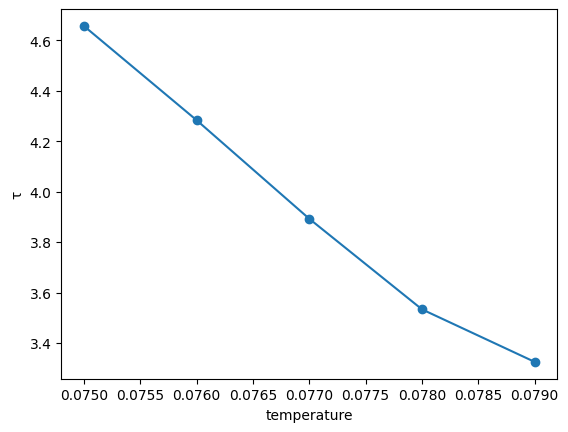

PyObject Text(24.000000000000007, 0.5, 'τ')

In [19]:
plt.plot(temps,log.(taus_opt),marker="o")
plt.xlabel("temperature")
plt.ylabel("τ")


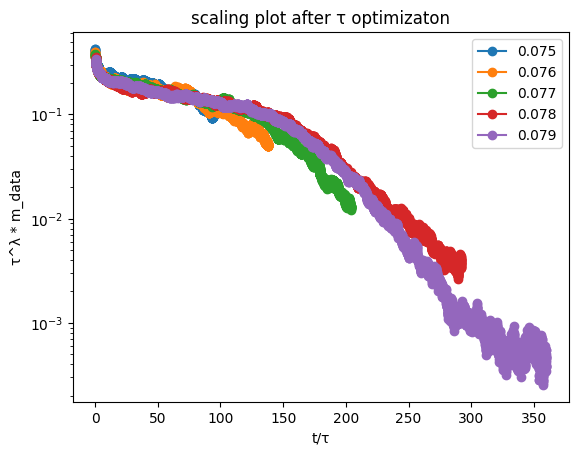

In [20]:
plt.figure()
for it in eachindex(temps)
	plt.semilogy(times[10:end] ./ taus_opt[it], (taus_opt[it]^lambda) * m_data[:, it][10:end], marker="o",label="$(temps[it])")
    #println((taus[it]^lambda) * m_data[:, it])
end
plt.title("scaling plot after τ optimizaton")
plt.xlabel("t/τ")
plt.ylabel("τ^λ * m_data")
plt.legend(loc="upper right")
plt.show()

In [21]:
x = 1.0
y = 0.9
n = 100
test = range(x,y,length=n)

1.0:-0.00101010101010101:0.9

In [22]:
test = LinRange(x,y,n)


100-element LinRange{Float64}:
 1.0,0.99899,0.99798,0.99697,0.99596,…,0.90404,0.90303,0.90202,0.90101,0.9